In [8]:
import requests
import pandas as pd
btc = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30").json()

# Convert to DataFrame
prices = btc['prices']
btc_df = pd.DataFrame(prices, columns=["Timestamp", "BTC_Close"])
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"], unit='ms').dt.date
btc_df = btc_df.groupby("Date").mean().drop(columns="Timestamp")

In [9]:

import yfinance as yf

# Get Apple stock history for the last 30 days
aapl = yf.Ticker("AAPL")
aapl_df = aapl.history(period="30d")[["Close"]].rename(columns={"Close": "AAPL_Close"})
aapl_df.index = aapl_df.index.date  # Convert DatetimeIndex to just dates

# btc_df is already created in your snippet
# btc_df has index = Date and column = BTC_Close

# Merge the two DataFrames on date
merged_df = pd.merge(aapl_df, btc_df, left_index=True, right_index=True)

# Display the merged dataset
print("📊 Merged BTC + AAPL Data:")
print(merged_df.head())

📊 Merged BTC + AAPL Data:
            AAPL_Close     BTC_Close
2025-03-07  239.070007  88034.046705
2025-03-10  227.479996  80965.162082
2025-03-11  220.839996  80892.741365
2025-03-12  216.979996  82503.197727
2025-03-13  209.679993  82313.751268


In [10]:
correlation = merged_df.corr().loc["AAPL_Close", "BTC_Close"]
print(f"\n📈 Correlation between AAPL and BTC (30d): {correlation:.2f}")


📈 Correlation between AAPL and BTC (30d): 0.39


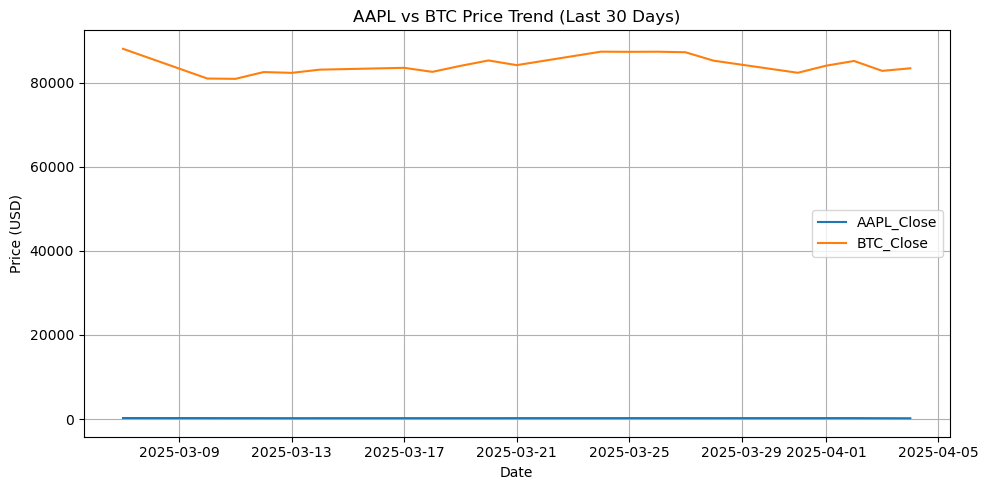

In [11]:
import matplotlib.pyplot as plt

merged_df.plot(title="AAPL vs BTC Price Trend (Last 30 Days)", figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


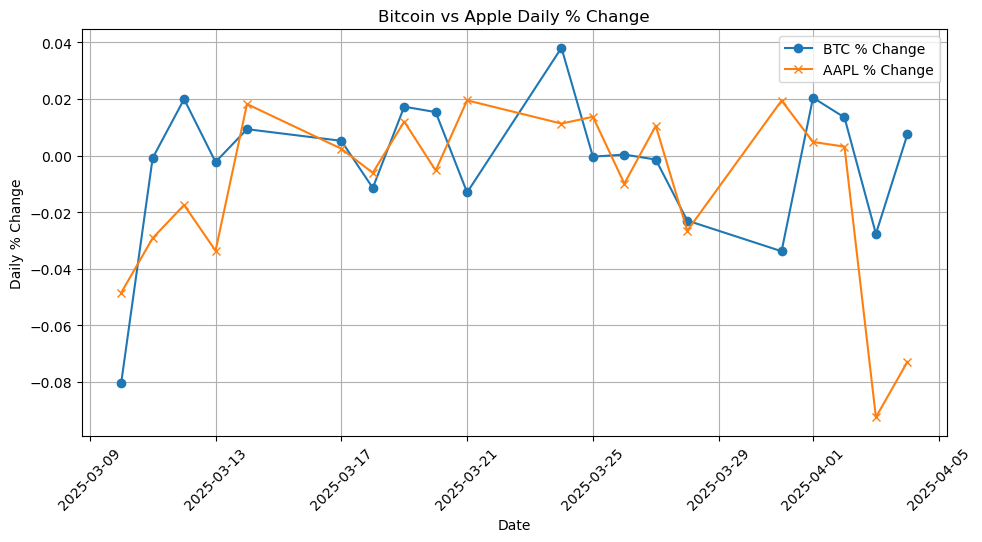

In [17]:
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt

# 🟡 1. Download BTC data (past 30 days)
btc = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30").json()
btc_prices = btc["prices"]
btc_df = pd.DataFrame(btc_prices, columns=["Timestamp", "BTC_Close"])
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"], unit="ms").dt.date
btc_df = btc_df.groupby("Date").mean().drop(columns="Timestamp").reset_index()

# 🟢 2. Download AAPL stock data and flatten columns
aapl_raw = yf.download("AAPL", period="30d", interval="1d")

# Flatten if MultiIndex
if isinstance(aapl_raw.columns, pd.MultiIndex):
    aapl_raw.columns = aapl_raw.columns.get_level_values(0)

# Reset index and prepare
aapl = aapl_raw.reset_index()[["Date", "Close"]]
aapl.rename(columns={"Close": "Stock_Close"}, inplace=True)
aapl["Date"] = pd.to_datetime(aapl["Date"]).dt.date

# 🔵 3. Merge BTC and Stock data
merged = pd.merge(btc_df, aapl, on="Date", how="inner")

# 🔴 4. Add % change columns
merged["btc_pct_change"] = merged["BTC_Close"].pct_change()
merged["stock_pct_change"] = merged["Stock_Close"].pct_change()

# 🟣 5. Plot
plt.figure(figsize=(10, 5))
plt.plot(merged["Date"], merged["btc_pct_change"], label="BTC % Change", marker='o')
plt.plot(merged["Date"], merged["stock_pct_change"], label="AAPL % Change", marker='x')
plt.title("Bitcoin vs Apple Daily % Change")
plt.xlabel("Date")
plt.ylabel("Daily % Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

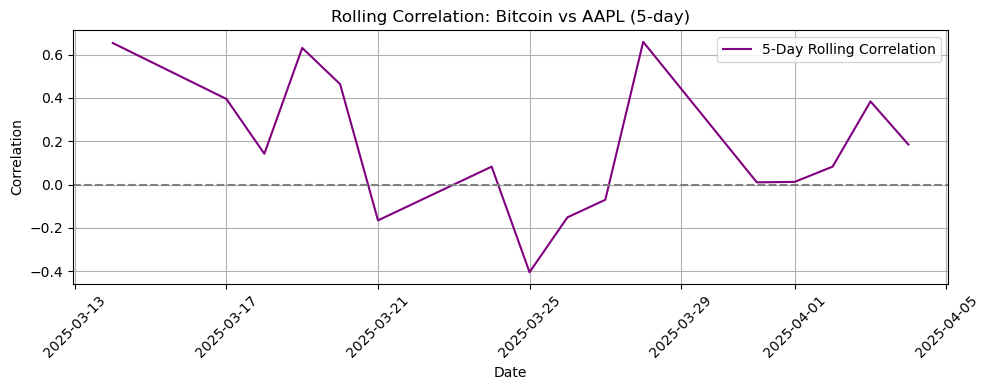

In [18]:
# Calculate rolling 5-day correlation between BTC & AAPL percent change
merged["rolling_corr"] = merged["btc_pct_change"].rolling(window=5).corr(merged["stock_pct_change"])

# Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(merged["Date"], merged["rolling_corr"], label="5-Day Rolling Correlation", color="purple")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Rolling Correlation: Bitcoin vs AAPL (5-day)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Rule-based signal: if BTC % change is > 2% and correlation > 0.5 → BUY STOCK
import numpy as np
merged["signal"] = np.where(
    (merged["btc_pct_change"] > 0.02) & (merged["rolling_corr"] > 0.5),
    "BUY AAPL",
    "HOLD"
)
print(merged[["Date", "btc_pct_change", "stock_pct_change", "rolling_corr", "signal"]].tail(10))

          Date  btc_pct_change  stock_pct_change  rolling_corr signal
11  2025-03-24        0.038040          0.011270      0.082873   HOLD
12  2025-03-25       -0.000419          0.013682     -0.404851   HOLD
13  2025-03-26        0.000338         -0.009922     -0.151434   HOLD
14  2025-03-27       -0.001442          0.010473     -0.070199   HOLD
15  2025-03-28       -0.022976         -0.026580      0.659383   HOLD
16  2025-03-31       -0.033817          0.019413      0.010296   HOLD
17  2025-04-01        0.020416          0.004772      0.012563   HOLD
18  2025-04-02        0.013439          0.003136      0.082979   HOLD
19  2025-04-03       -0.027666         -0.092456      0.384118   HOLD
20  2025-04-04        0.007422         -0.072887      0.185002   HOLD


In [21]:
import pandas as pd
import numpy as np

# Your merged dataframe already has:
# - btc_pct_change
# - stock_pct_change
# - rolling_corr

# Shift AAPL's % change back 1 day → today's features predict tomorrow's outcome
merged["target"] = merged["stock_pct_change"].shift(-1)
merged["target_class"] = np.where(merged["target"] > 0, 1, 0)  # 1 if stock goes up next day

# Drop last row (no target)
merged = merged.dropna(subset=["target_class"])

# Final features
features = merged[["btc_pct_change", "rolling_corr", "stock_pct_change"]]
labels = merged["target_class"]

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.50      0.33         2

    accuracy                           0.20         5
   macro avg       0.12      0.25      0.17         5
weighted avg       0.10      0.20      0.13         5



In [62]:
aapl = yf.download("AAPL", period="180d", interval="1d")[['Close']]

[*********************100%***********************]  1 of 1 completed


In [63]:
btc = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=180").json()

In [64]:
merged["btc_pct_change"]
merged["stock_pct_change"]

Series([], Name: stock_pct_change, dtype: float64)

In [65]:
# Rolling average of BTC change
merged["btc_rolling_avg"] = merged["btc_pct_change"].rolling(3).mean()

# BTC volatility
merged["btc_volatility"] = merged["btc_pct_change"].rolling(5).std()

# AAPL momentum
merged["aapl_rolling_avg"] = merged["stock_pct_change"].rolling(3).mean()

# Lag previous day's movement
merged["prev_day_stock_change"] = merged["stock_pct_change"].shift(1)

In [66]:
merged["target"] = (merged["stock_pct_change"].shift(-1) > 0).astype(int)

In [67]:
merged.dropna(inplace=True)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features to use
features = [
    "btc_pct_change",
    "stock_pct_change",
    "btc_rolling_avg",
    "btc_volatility",
    "aapl_rolling_avg",
    "prev_day_stock_change"
]

X = merged[features]
y = merged["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [71]:
aapl = yf.download("AAPL", period="30d", interval="1d")[['Close']]
aapl.reset_index(inplace=True)  # <--- Important
aapl.rename(columns={"Close": "Stock_Close"}, inplace=True)
aapl["Date"] = pd.to_datetime(aapl["Date"]).dt.date

[*********************100%***********************]  1 of 1 completed


In [72]:
print("📅 AAPL dates:", aapl["Date"].tail())

📅 AAPL dates: 25    2025-03-31
26    2025-04-01
27    2025-04-02
28    2025-04-03
29    2025-04-04
Name: Date, dtype: object


In [74]:
import yfinance as yf
import pandas as pd
import requests

# 🟩 1. Get AAPL stock data
aapl = yf.download("AAPL", period="30d", interval="1d")[['Close']]

# ✅ Fix multi-index if any
aapl.columns = aapl.columns.get_level_values(0)

# ✅ Rename and format
aapl = aapl.reset_index()
aapl.rename(columns={"Close": "Stock_Close"}, inplace=True)
aapl["Date"] = pd.to_datetime(aapl["Date"]).dt.date

# 🟩 2. Get BTC data
btc = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30").json()
btc_df = pd.DataFrame(btc["prices"], columns=["Timestamp", "BTC_Close"])
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"], unit='ms').dt.date
btc_df = btc_df.groupby("Date").mean().drop(columns="Timestamp").reset_index()

# 🟦 3. Merge cleanly
merged = pd.merge(btc_df, aapl, on="Date", how="inner")

# 🔁 4. Calculate % change
merged["btc_pct_change"] = merged["BTC_Close"].pct_change()
merged["stock_pct_change"] = merged["Stock_Close"].pct_change()

# ✅ Preview
print(merged.head())

[*********************100%***********************]  1 of 1 completed

         Date     BTC_Close  Stock_Close  btc_pct_change  stock_pct_change
0  2025-03-07  88145.118535   239.070007             NaN               NaN
1  2025-03-10  80965.162082   227.479996       -0.081456         -0.048480
2  2025-03-11  80892.741365   220.839996       -0.000894         -0.029189
3  2025-03-12  82503.197727   216.979996        0.019909         -0.017479
4  2025-03-13  82313.751268   209.679993       -0.002296         -0.033644


In [75]:
# Rolling correlation over 3 days (between BTC and AAPL)
merged["rolling_corr"] = merged["btc_pct_change"].rolling(window=3).corr(merged["stock_pct_change"])

# Signal: BTC moves > 2% (up or down)
merged["signal"] = merged["btc_pct_change"].apply(lambda x: 1 if abs(x) > 0.02 else 0)

# Target: whether stock went up the next day
merged["target"] = merged["stock_pct_change"].shift(-1) > 0
merged["target_class"] = merged["target"].astype(int)  # Convert to 0/1

# Drop NaN rows caused by rolling window/shift
merged.dropna(inplace=True)

print("✅ Final dataset preview:")
print(merged[["btc_pct_change", "stock_pct_change", "rolling_corr", "signal", "target_class"]].head())


✅ Final dataset preview:
   btc_pct_change  stock_pct_change  rolling_corr  signal  target_class
3        0.019909         -0.017479      0.982410       0             0
4       -0.002296         -0.033644      0.977271       0             1
5        0.009303          0.018171      0.329364       0             1
6        0.005183          0.002389      0.998421       0             0
7       -0.011460         -0.006121      0.874570       0             1


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = merged[["btc_pct_change", "stock_pct_change", "rolling_corr", "signal"]]
y = merged["target_class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

[[1 1]
 [0 2]]


In [77]:
aapl = yf.download("AAPL", period="6mo", interval="1d")[['Close']]

[*********************100%***********************]  1 of 1 completed


In [78]:
# Lag features
merged["btc_pct_lag1"] = merged["btc_pct_change"].shift(1)
merged["stock_pct_lag1"] = merged["stock_pct_change"].shift(1)

# Rolling volatility
merged["btc_volatility"] = merged["btc_pct_change"].rolling(window=5).std()
merged["aapl_volatility"] = merged["stock_pct_change"].rolling(window=5).std()

# Optionally: Volume (if using more API)
# merged["btc_volume"] = ...
# merged["aapl_volume"] = yf.download("AAPL", ...)[['Volume']]

In [79]:
from xgboost import XGBClassifier
# Calculate scale_pos_weight for XGBoost
from collections import Counter

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
balanced_weight = neg / pos
model = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=balanced_weight,
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [80]:
from xgboost import XGBClassifier

model = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=balanced_weight,
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [83]:
print(merged.columns.tolist())

['Date', 'BTC_Close', 'Stock_Close', 'btc_pct_change', 'stock_pct_change', 'rolling_corr', 'signal', 'target', 'target_class', 'btc_pct_lag1', 'stock_pct_lag1', 'btc_volatility', 'aapl_volatility']


In [85]:
feature_cols = [
    "btc_pct_change",
    "stock_pct_change",
    "rolling_corr",
    "signal",
]
latest = merged.iloc[-1:]  # latest row
signal = model.predict(latest[feature_cols])[0]

if signal == 1:
    print("💰 AI suggests BUY AAPL based on crypto movement.")
else:
    print("🚫 AI suggests HOLD or SELL.")

🚫 AI suggests HOLD or SELL.


In [86]:
initial_cash = 10_000  # Starting capital
cash = initial_cash
aapl_qty = 0
portfolio_values = []

for i in range(len(merged)):
    row = merged.iloc[i]
    
    # Skip if any feature is missing
    if row[feature_cols].isnull().any():
        portfolio_values.append(cash + aapl_qty * row["Stock_Close"])
        continue

    X = row[feature_cols].values.reshape(1, -1)
    signal = model.predict(X)[0]
    aapl_price = row["Stock_Close"]

    # Decision logic
    if signal == 1 and aapl_qty == 0:
        # Buy AAPL
        aapl_qty = cash // aapl_price
        cash -= aapl_qty * aapl_price
    elif signal == 0 and aapl_qty > 0:
        # Sell AAPL
        cash += aapl_qty * aapl_price
        aapl_qty = 0

    # Portfolio value = cash + current stock value
    total_value = cash + aapl_qty * aapl_price
    portfolio_values.append(total_value)

# Add to dataframe for visualization
merged = merged.iloc[:len(portfolio_values)].copy()
merged["portfolio_value"] = portfolio_values

/var/folders/z2/wl288m9n139_4ywpb2k5s8t40000gn/T/ipykernel_15681/585991057.py:11: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z2/wl288m9n139_4ywpb2k5s8t40000gn/T/ipykernel_15681/585991057.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/lakshmikrishnan/miniconda3/envs/bankruptcy-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lakshmikrishnan/miniconda3/envs/bankruptcy-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


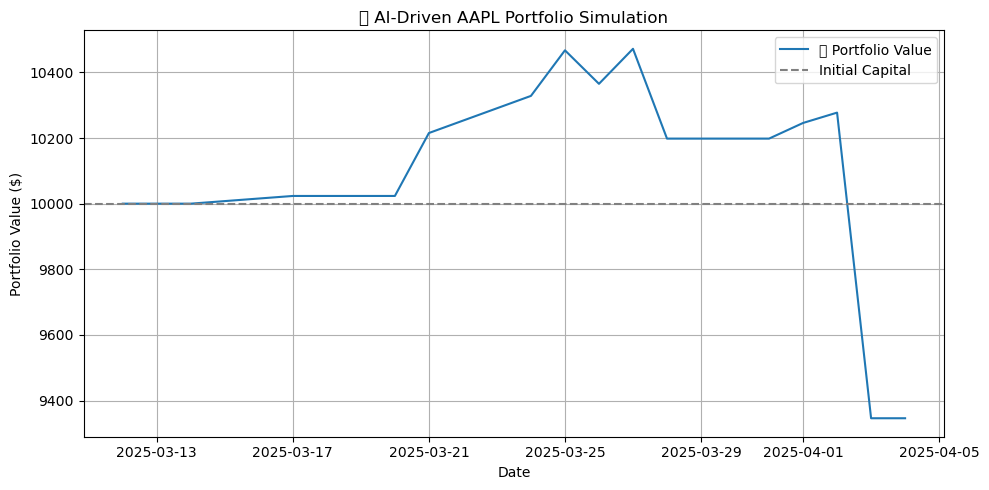

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(merged["Date"], merged["portfolio_value"], label="📈 Portfolio Value")
plt.axhline(y=initial_cash, color='gray', linestyle='--', label="Initial Capital")
plt.title("🔁 AI-Driven AAPL Portfolio Simulation")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
buy_dates = []
sell_dates = []

cash = 10_000
aapl_qty = 0
portfolio_values = []

for i in range(len(merged)):
    row = merged.iloc[i]
    if row[feature_cols].isnull().any():
        portfolio_values.append(cash + aapl_qty * row["Stock_Close"])
        continue

    X = row[feature_cols].values.reshape(1, -1)
    signal = model.predict(X)[0]
    aapl_price = row["Stock_Close"]

    if signal == 1 and aapl_qty == 0:
        # BUY
        aapl_qty = cash // aapl_price
        cash -= aapl_qty * aapl_price
        buy_dates.append(row["Date"])
    elif signal == 0 and aapl_qty > 0:
        # SELL
        cash += aapl_qty * aapl_price
        aapl_qty = 0
        sell_dates.append(row["Date"])

    total_value = cash + aapl_qty * aapl_price
    portfolio_values.append(total_value)

merged["portfolio_value"] = portfolio_values

In [89]:
initial_price = merged.iloc[0]["Stock_Close"]
buy_hold_value = [10_000 * price / initial_price for price in merged["Stock_Close"]]
merged["buy_hold_value"] = buy_hold_value

/var/folders/z2/wl288m9n139_4ywpb2k5s8t40000gn/T/ipykernel_15681/2901138499.py:19: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z2/wl288m9n139_4ywpb2k5s8t40000gn/T/ipykernel_15681/2901138499.py:19: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z2/wl288m9n139_4ywpb2k5s8t40000gn/T/ipykernel_15681/2901138499.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/lakshmikrishnan/miniconda3/envs/bankruptcy-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lakshmikrishnan/miniconda3/envs/bankruptcy-ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: U

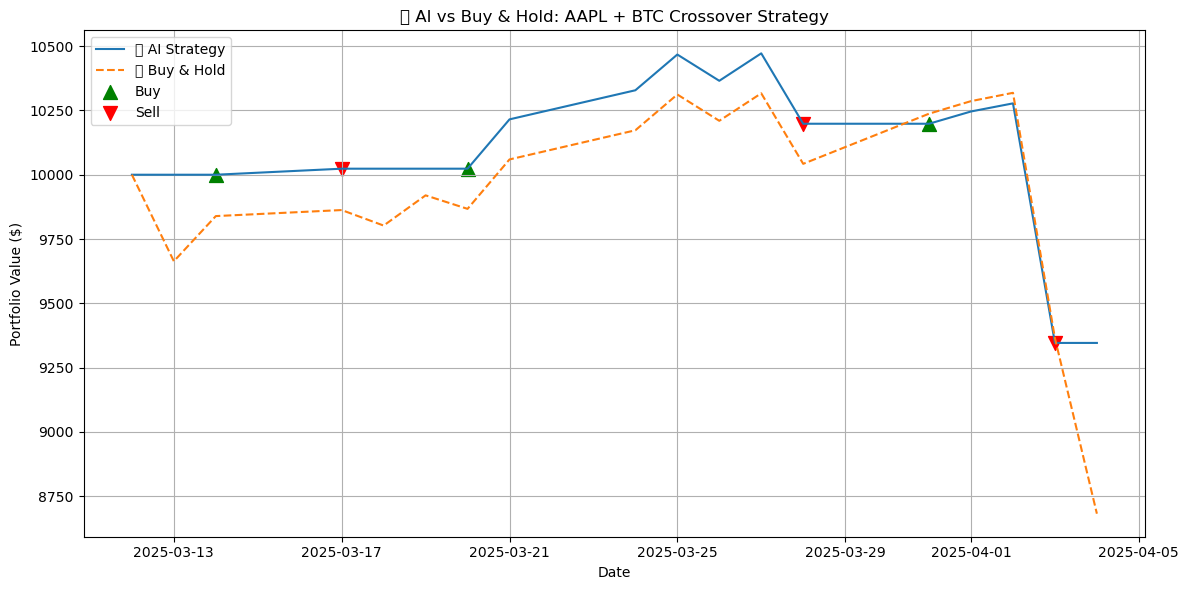

In [90]:
plt.figure(figsize=(12,6))
plt.plot(merged["Date"], merged["portfolio_value"], label="💡 AI Strategy")
plt.plot(merged["Date"], merged["buy_hold_value"], label="📈 Buy & Hold", linestyle='--')

# Add markers
plt.scatter(merged[merged["Date"].isin(buy_dates)]["Date"], 
            merged[merged["Date"].isin(buy_dates)]["portfolio_value"], 
            marker="^", color="green", label="Buy", s=100)

plt.scatter(merged[merged["Date"].isin(sell_dates)]["Date"], 
            merged[merged["Date"].isin(sell_dates)]["portfolio_value"], 
            marker="v", color="red", label="Sell", s=100)

plt.title("🔁 AI vs Buy & Hold: AAPL + BTC Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()